```
This file is part of sscx-connectome-manipulations.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# Interneuron rewiring preparation

Rewiring of interneurons in SSCx-O1 connectome, adding an inhibitory-targeting interneuron class in accordance with MICrONS data characterized by Schneider-Mizell et al. (2023).

ℹ️ Reproduction of interneuron rewiring experiment described in [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- [Connectome-Manipulator](https://github.com/BlueBrain/connectome-manipulator) (Python venv)
- [ConnectomeUtilities](https://github.com/BlueBrain/ConnectomeUtilities) (Python venv)
- [SSCx network model](https://doi.org/10.5281/zenodo.8026353)
- Connectivity matrix based on new pruning rule, available on [Zenodo](https://zenodo.org/)

In [1]:
import json
import matplotlib.pyplot as plt
import neurom as nm
import numpy as np
import pandas as pd
import os
import pickle
import tqdm

from bluepysnap import Circuit
from bluepysnap.morph import MorphHelper
from connectome_manipulator.access_functions import get_node_ids
from connectome_manipulator.connectome_comparison import structural_comparator
from connectome_manipulator.model_building import model_types, model_building
from conntility.connectivity import ConnectivityMatrix

In [48]:
# Save path for output figures
figs_path = './figs'
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

_SSCx network model:_ Download and extract `O1_data_physiology_withfix.xz` and set path accordingly:

In [8]:
# Path to SSCx network model
circuit_path = '/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data'

_Connectivity matrix based on new pruning rule:_ Download and extract `interneuron_rewiring.xz` from Zenodo and set path accordingly:

In [3]:
# Path to interneuron rewiring dataset from Zenodo
data_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring'

## Load and check connectivity

Connectivity matrix has been pre-computed by pruning the full set of axo-dendritic appositions in a target-specific way, as described in the accompanying article.

In [4]:
conn_file = os.path.join(data_path, 'connectivity_matrices', 'SSCX_hex0_inh_tc__hex0_rewired.h5')
conn_name = os.path.splitext(os.path.split(conn_file)[-1])[0]
conn = ConnectivityMatrix.from_h5(conn_file)

In [5]:
adj = conn.matrix.tocsc().astype(bool)
print(f'conn.matrix:\n{conn.matrix.__repr__}')
print(f'adj:\n{adj.__repr__}')

conn.matrix:
<bound method spmatrix.__repr__ of <30190x30190 sparse matrix of type '<class 'numpy.float32'>'
	with 1593595 stored elements in COOrdinate format>>
adj:
<bound method spmatrix.__repr__ of <30190x30190 sparse matrix of type '<class 'numpy.bool_'>'
	with 733742 stored elements in Compressed Sparse Column format>>


In [6]:
conn.edges

,afferent_section_id,afferent_section_pos,conductance,afferent_section_type,afferent_center_x,afferent_center_y,afferent_center_z
0,1056,0.890600,1.354288,3,4578.264160,-1351.421021,-1703.856323
1,1011,0.351320,1.169900,3,4505.049805,-1395.794189,-1759.699951
2,1029,0.131612,2.678915,3,4467.456543,-1383.090698,-1714.732300
3,1028,0.984917,1.325603,3,4411.163086,-1462.080933,-1728.275146
4,1002,0.644739,2.356690,3,4487.819336,-1433.519897,-1764.283203
...,...,...,...,...,...,...,...
18429139,101,0.071995,2.263319,3,3997.840332,-1379.646362,-2683.626709
18429140,116,0.605943,2.302073,3,3967.063965,-1536.515137,-2634.284668
18429141,147,0.104562,2.302073,3,4015.851562,-1322.729126,-2593.606934
18429142,98,0.041036,2.326718,3,3977.909180,-1374.837036,-2661.439697


In [7]:
assert np.array_equal(conn._edge_indices['row'], conn.matrix.row)
assert np.array_equal(conn._edge_indices['col'], conn.matrix.col)

In [9]:
# Node ID mapping from full SSCx to extracted SSCx-O1 (seven column subvolume)
map_file = os.path.join(circuit_path, 'mapping.json')
with open(map_file, 'r') as f:
    map_dict = json.load(f)
df_map = pd.DataFrame(map_dict['S1nonbarrel_neurons'])
df_map.set_index('old_id', inplace=True)

In [10]:
conn_gids = df_map.loc[conn.gids].to_numpy().flatten()

In [11]:
# Check source/target m-types
src_types = np.unique(conn.mtype[np.unique(conn.matrix.row)]).tolist()
tgt_types = np.unique(conn.mtype[np.unique(conn.matrix.col)]).tolist()
print(f'Source m-types ({len(src_types)}):\n{src_types}\n')
print(f'Target m-types ({len(tgt_types)}):\n{tgt_types}')

Source m-types (8):
['L23_BTC', 'L23_SBC', 'L4_BTC', 'L4_SBC', 'L5_BTC', 'L5_SBC', 'L6_BTC', 'L6_SBC']

Target m-types (60):
['L1_DAC', 'L1_HAC', 'L1_LAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SAC', 'L23_BP', 'L23_BTC', 'L23_CHC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_SBC', 'L2_IPC', 'L2_TPC:A', 'L2_TPC:B', 'L3_TPC:A', 'L3_TPC:C', 'L4_BP', 'L4_BTC', 'L4_CHC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_SBC', 'L4_SSC', 'L4_TPC', 'L4_UPC', 'L5_BP', 'L5_BTC', 'L5_CHC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_TPC:A', 'L5_TPC:B', 'L5_TPC:C', 'L5_UPC', 'L6_BP', 'L6_BPC', 'L6_BTC', 'L6_CHC', 'L6_DBC', 'L6_HPC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC', 'L6_NGC', 'L6_SBC', 'L6_TPC:A', 'L6_TPC:C', 'L6_UPC']


In [12]:
# Divide into EXC/INH target types
tgt_exc_types = np.unique(conn.mtype[conn.synapse_class == 'EXC']).tolist()
tgt_inh_types = np.unique(conn.mtype[conn.synapse_class == 'INH']).tolist()
tgt_inh_types_manip = np.intersect1d(tgt_inh_types, src_types)
tgt_inh_types_nonmanip = np.setdiff1d(tgt_inh_types, src_types)
print(f'EXC target m-types ({len(tgt_exc_types)}):\n{tgt_exc_types}\n')
print(f'INH target m-types ({len(tgt_inh_types)}):\n{tgt_inh_types}\n')
print(f'Rewired INH target m-types ({len(tgt_inh_types_manip)}):\n{tgt_inh_types_manip}\n')
print(f'Non-rewired INH target m-types ({len(tgt_inh_types_nonmanip)}):\n{tgt_inh_types_nonmanip}')

EXC target m-types (18):
['L2_IPC', 'L2_TPC:A', 'L2_TPC:B', 'L3_TPC:A', 'L3_TPC:C', 'L4_SSC', 'L4_TPC', 'L4_UPC', 'L5_TPC:A', 'L5_TPC:B', 'L5_TPC:C', 'L5_UPC', 'L6_BPC', 'L6_HPC', 'L6_IPC', 'L6_TPC:A', 'L6_TPC:C', 'L6_UPC']

INH target m-types (42):
['L1_DAC', 'L1_HAC', 'L1_LAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SAC', 'L23_BP', 'L23_BTC', 'L23_CHC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_SBC', 'L4_BP', 'L4_BTC', 'L4_CHC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_SBC', 'L5_BP', 'L5_BTC', 'L5_CHC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L6_BP', 'L6_BTC', 'L6_CHC', 'L6_DBC', 'L6_LBC', 'L6_MC', 'L6_NBC', 'L6_NGC', 'L6_SBC']

Rewired INH target m-types (8):
['L23_BTC' 'L23_SBC' 'L4_BTC' 'L4_SBC' 'L5_BTC' 'L5_SBC' 'L6_BTC' 'L6_SBC']

Non-rewired INH target m-types (34):
['L1_DAC' 'L1_HAC' 'L1_LAC' 'L1_NGC-DA' 'L1_NGC-SA' 'L1_SAC' 'L23_BP'
 'L23_CHC' 'L23_DBC' 'L23_LBC' 'L23_MC' 'L23_NBC' 'L23_NGC' 'L4_BP'
 'L4_CHC' 'L4_DBC' 'L4_LBC' 'L4_MC' '

In [14]:
# Convert to synaptome (i.e., matrix containing numbers of synapses per connection)
synaptome = conn.matrix.copy()
synaptome.data = np.ones_like(synaptome.data)
synaptome = synaptome.tocsc().astype(int)
print(f'Synaptome with {synaptome.sum()} synapses')

Synaptome with 1593595 synapses


In [15]:
# Load and check original circuit
circuit_name = 'SSCx-HexO1-Release'
circuit_config = os.path.join(circuit_path, 'circuit_config.json')  # Released 210K nbS1 (SSCx HexO1) physiology circuit from [Isbister et al. 2023]
c = Circuit(circuit_config)
nodes = c.nodes["S1nonbarrel_neurons"]
edges = c.edges["S1nonbarrel_neurons__S1nonbarrel_neurons__chemical"]
print(f'Circuit "{circuit_name}"')
print(f"Total number of neurons: {nodes.size}")
print(f"Total number of synapses: {edges.size}")


Circuit "SSCx-HexO1-Release"
Total number of neurons: 211712
Total number of synapses: 407127134


In [21]:
# Check GID mapping and restrict to selected types
assert np.array_equal(conn_gids, nodes.ids('hex0'))

src_sel = get_node_ids(nodes, {'node_set': 'hex0', 'mtype': src_types})
tgt_sel = get_node_ids(nodes, {'node_set': 'hex0', 'mtype': tgt_types})

n_conn = adj.count_nonzero()
adj = adj[:, np.isin(conn_gids, tgt_sel)][np.isin(conn_gids, src_sel), :]
synaptome = synaptome[:, np.isin(conn_gids, tgt_sel)][np.isin(conn_gids, src_sel), :]

assert adj.count_nonzero() == n_conn, 'ERROR: Connections missing!'
assert synaptome.count_nonzero() == n_conn, 'ERROR: Connections missing!'

## Create and save models for rewiring

For running rewiring, we need to specify the (stochastic) models for defining connectivity as well as for physiology.

ℹ️ These models are also contained in the Zenodo dataset

In [17]:
# Output path to store models
model_root_path = os.path.join(data_path, 'model_building')

In [18]:
model_path = os.path.join(model_root_path, f"{circuit_name}/model")
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Adjacency matrix (stored as LookupTableModel)
... to be used as connection probability model

In [22]:
adj_model = model_types.LookupTableModel.init_from_sparse_matrix(adj, src_sel, tgt_sel)
adj_model_name = f"ConnProbAdjModel-{conn_name}"
adj_model.save_model(model_path, adj_model_name)
print(adj_model)
adj_model_file = os.path.join(model_path, adj_model_name + ".json")
assert os.path.exists(adj_model_file), f'ERROR: Model file "{adj_model_file}" not saved!'
print(f'Model saved to "{adj_model_file}"\n')

LookupTableModel
  <530x30190 sparse matrix of type '<class 'numpy.bool_'>'
	with 733742 stored elements in Compressed Sparse Column format>
  Value range: True (dtype: bool)
Model saved to "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/model_building/SSCx-HexO1-Release/model/ConnProbAdjModel-SSCX_hex0_inh_tc__hex0_rewired.json"



### Synaptome with #synapses/connection (stored as LookupTableModel)
...to be used to provide #synapses/connection during rewiring

In [23]:
syn_model = model_types.LookupTableModel.init_from_sparse_matrix(synaptome, src_sel, tgt_sel)
syn_model_name = f"SynaptomeModel-{conn_name}"
syn_model.save_model(model_path, syn_model_name)
print(syn_model)
syn_model_file = os.path.join(model_path, syn_model_name + ".json")
assert os.path.exists(syn_model_file), f'ERROR: Model file "{syn_model_file}" not saved!'
print(f'Model saved to "{syn_model_file}"\n')

LookupTableModel
  <530x30190 sparse matrix of type '<class 'numpy.int64'>'
	with 733742 stored elements in Compressed Sparse Column format>
  Value range: 1..100 (dtype: int64)
Model saved to "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/model_building/SSCx-HexO1-Release/model/SynaptomeModel-SSCX_hex0_inh_tc__hex0_rewired.json"



### Edges table with synapse positions (stored as PropsTableModel)
...to be used to load synapse positions during rewiring

In [24]:
# Add source/target node IDs to edges properties table
etab = conn.edges.copy()
etab["@source_node"] = conn_gids[conn._edge_indices["row"]]  # Node IDs (already mapped to extracted SSCx-O1)
etab["@target_node"] = conn_gids[conn._edge_indices["col"]]
assert np.all(np.isin(etab["@source_node"], src_sel))
assert np.all(np.isin(etab["@target_node"], tgt_sel))

In [25]:
# Initialize & store model
props_sel = ["@source_node", "@target_node"] + sorted(set(conn.edges.columns) - {'conductance'})
props_table = etab[props_sel]
assert props_table.shape[0] == synaptome.sum(), 'ERROR: Synapse count mismatch!'
syn_pos_model = model_types.PropsTableModel(props_table=props_table)
syn_pos_model_name = f"SynapsePositionModel-{conn_name}"
syn_pos_model.save_model(model_path, syn_pos_model_name)
print(syn_pos_model)
syn_pos_model_file = os.path.join(model_path, syn_pos_model_name + ".json")
assert os.path.exists(syn_pos_model_file), f'ERROR: Model file "{syn_pos_model_file}" not saved!'
print(f'Model saved to "{syn_pos_model_file}"\n')

PropsTableModel
  Properties: ['afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_pos', 'afferent_section_type']
  Entries: 1593595
Model saved to "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/model_building/SSCx-HexO1-Release/model/SynapsePositionModel-SSCX_hex0_inh_tc__hex0_rewired.json"



### Building stochastic physiology models required for rewiring
- Based on central column (hex0) of SSCx-O1 connectome
- Only using connections from BTC/SBC to all m-types

In [26]:
print(f"Source m-types: {src_types}")
print(f"Target m-types: {tgt_types}")

Source m-types: ['L23_BTC', 'L23_SBC', 'L4_BTC', 'L4_SBC', 'L5_BTC', 'L5_SBC', 'L6_BTC', 'L6_SBC']
Target m-types: ['L1_DAC', 'L1_HAC', 'L1_LAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SAC', 'L23_BP', 'L23_BTC', 'L23_CHC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_SBC', 'L2_IPC', 'L2_TPC:A', 'L2_TPC:B', 'L3_TPC:A', 'L3_TPC:C', 'L4_BP', 'L4_BTC', 'L4_CHC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_SBC', 'L4_SSC', 'L4_TPC', 'L4_UPC', 'L5_BP', 'L5_BTC', 'L5_CHC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_TPC:A', 'L5_TPC:B', 'L5_TPC:C', 'L5_UPC', 'L6_BP', 'L6_BPC', 'L6_BTC', 'L6_CHC', 'L6_DBC', 'L6_HPC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC', 'L6_NGC', 'L6_SBC', 'L6_TPC:A', 'L6_TPC:C', 'L6_UPC']


In [27]:
output_path = model_root_path
config_path = '../configs'

In [28]:
def default_model_config(output_path, circuit_name, circuit_config, seed=7531):
    """Generates a default model config dict w/o any specific model."""

    model_config = {}
    model_config['working_dir'] = os.path.join(output_path, circuit_name)
    model_config['out_dir'] = model_config['working_dir']
    model_config['seed'] = seed
    model_config['circuit_config'] = circuit_config

    return model_config

def export_model_config(model_config, config_path, print_cmd=True):
    """Writes model config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    fn = f'model_config__{model_config["model"]["name"]}.json'
    for cpath in config_path:
        if not os.path.exists(cpath):
            os.makedirs(cpath)
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(model_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")
    # print(json.dumps(model_config, indent=2))

    if print_cmd:
        print()
        print_launch_cmd(cpath, fn)

def print_launch_cmd(config_path, config_fn):
    run_cmd = f"sbatch run_model_building.sh {config_fn} --force-reextract --force-rebuild"
    print(f"# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:")
    print(f"cd {config_path}")
    print(run_cmd)

#### Distance-dependent axonal delay model (DistDepDelayModel)

Stochastic model for axonal delays, with mean delays linearly dependent on Euclidean distance between pre-synaptic neuron and synapse position on the dendrite.

ℹ️ Adapt `run_model_building.sh` according to system configuration and use below launch command to run model fitting

In [29]:
# Linear distance-dependent delay model
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'DistDepDelay-SSCxO1-Hex0IntNrn',
                         'fct': {'source': 'delay',
                                 'kwargs': {'sel_src': {'node_set': 'hex0', 'mtype': src_types},
                                            'sel_dest': {'node_set': 'hex0', 'mtype': tgt_types},
                                            'sample_size': None,
                                            'bin_size_um': 50,
                                            'max_range_um': None}}}
export_model_config(model_config, config_path)

Config file model_config__DistDepDelay-SSCxO1-Hex0IntNrn.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__DistDepDelay-SSCxO1-Hex0IntNrn.json --force-reextract --force-rebuild


#### Physiological properties model (ConnPropsModel) per src/tgt m-type

Physiological parameter distributions are fit against data from the original connectome for all pairs of pre- and post-synaptic m-types.

ℹ️ Adapt `run_model_building.sh` according to system configuration and use below launch command to run model fitting

In [30]:
# Connection/synapse properties model
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnPropsPerPathway-SSCxO1-Hex0IntNrn',
                         'fct': {'source': 'conn_props',
                                 'kwargs': {'sel_src': {'node_set': 'hex0', 'mtype': src_types},
                                            'sel_dest': {'node_set': 'hex0', 'mtype': tgt_types},
                                            'min_sample_size_per_group': 10,
                                            'max_sample_size_per_group': 10000,
                                            'distr_types': {'conductance': 'gamma',
                                                            'conductance_scale_factor': 'constant',
                                                            'decay_time': 'truncnorm',
                                                            'depression_time': 'gamma',
                                                            'facilitation_time': 'gamma',
                                                            'n_rrp_vesicles': 'discrete',
                                                            'n_syn_per_conn': 'discrete',
                                                            'syn_type_id': 'discrete',
                                                            'u_hill_coefficient': 'discrete',
                                                            'u_syn': 'truncnorm',
                                                            'Use_d_TM': 'zero',  # Not used
                                                            'Use_p_TM': 'zero',  # Not used
                                                            'gmax_d_AMPA': 'zero',  # Not used
                                                            'gmax_p_AMPA': 'zero',  # Not used
                                                            'rho0_GB': 'zero',  # Not used
                                                            'spine_length': 'zero',  # Not used
                                                            'theta_d': 'zero',  # Not used
                                                            'theta_p': 'zero',  # Not used
                                                            'volume_CR': 'zero'},  # Not used
                                            'data_types': {'n_rrp_vesicles': 'int',
                                                           'n_syn_per_conn': 'int',
                                                           'syn_type_id': 'int'},
                                            'data_bounds': {},
                                            'plot_sample_size': 10000}}}
export_model_config(model_config, config_path)

Config file model_config__ConnPropsPerPathway-SSCxO1-Hex0IntNrn.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnPropsPerPathway-SSCxO1-Hex0IntNrn.json --force-reextract --force-rebuild


## Set up & run rewiring
- Central column (hex0) of SSCx-O1 connectome
- Connections from BTC/SBC to all m-types

ℹ️ Adapt `run_rewiring_parallel.sh` according to system configuration and use below launch command to run rewiring

In [31]:
# Output path for rewired circuits
output_circuit_path = os.path.join(data_path, 'circuits')

In [32]:
def default_manip_config(circuit_config, seed=3210, N_split=None):
    """Generates a default manipulation config dict w/o any specific manipulation."""
    manip_config = {}
    manip_config['circuit_config'] = circuit_config
    manip_config['seed'] = seed
    if N_split is not None:
        manip_config['N_split_nodes'] = N_split
    return manip_config

def export_manip_config(manip_config, config_path, print_cmd=False, circuit_name=None, output_base_path=None, N_parallel=None, calib_run=False):
    """Writes manipulation config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    fn = f'manip_config__{manip_config["manip"]["name"]}.json'
    for cpath in config_path:
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(manip_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")

    if print_cmd:
        assert circuit_name is not None and output_base_path is not None and N_parallel is not None, \
            "ERROR: circuit_name/output_base_path/N_parallel required for printing launch command!"
        print()
        output_dir = os.path.join(output_base_path, circuit_name + f'__{manip_config["manip"]["name"]}')
        print_launch_cmd(cpath, fn, output_dir, N_parallel, calib_run)

def print_launch_cmd(config_path, config_fn, output_dir, N_parallel, calib_run):
    if calib_run:
        run_cmd = f'sbatch run_rewiring_parallel__estimation_run.sh "{config_fn}" "{output_dir}" {N_parallel}'
    else:
        run_cmd = f'sbatch run_rewiring_parallel.sh "{config_fn}" "{output_dir}" {N_parallel}'
    print(f"# LAUNCH COMMAND: [DON'T LAUNCH FROM WITHIN ANOTHER SLURM ALLOCATION!]")
    print(f"cd {config_path}")
    print(run_cmd)


In [33]:
# Model locations (hex0 column models!!)
models_path = os.path.join(model_root_path, circuit_name, 'model')  # Location of model files

prob_model_file = os.path.join(models_path, 'ConnProbAdjModel-SSCX_hex0_inh_tc__hex0_rewired.json')
syn_model_file = os.path.join(models_path, 'SynaptomeModel-SSCX_hex0_inh_tc__hex0_rewired.json')
syn_pos_file = os.path.join(models_path, 'SynapsePositionModel-SSCX_hex0_inh_tc__hex0_rewired.json')
delay_model_file = os.path.join(models_path, 'DistDepDelay-SSCxO1-Hex0IntNrn.json')
props_model_file = os.path.join(models_path, 'ConnPropsPerPathway-SSCxO1-Hex0IntNrn.json')


In [34]:
manip_config = default_manip_config(circuit_config, seed=3210)
manip_config['manip'] = {'name': conn_name,
                         'fcts': [{'source': 'conn_rewiring',
                                   'sel_src': {'node_set': 'hex0', 'mtype': src_types},
                                   'sel_dest': {'node_set': 'hex0', 'mtype': tgt_types},
                                   'syn_class': 'INH',
                                   'keep_indegree': False,
                                   'reuse_conns': False,
                                   'keep_conns': False,
                                   'gen_method': 'randomize',
                                   'syn_pos_mode': 'external',
                                   'amount_pct': 100,
                                   'model_config': {'prob_model_spec': {'file': prob_model_file},
                                                    'nsynconn_model_spec': {'file': syn_model_file},
                                                    'syn_pos_model_spec': {'file': syn_pos_file},
                                                    'delay_model_spec': {'file': delay_model_file},
                                                    'props_model_spec': {'file': props_model_file}}}]}
export_manip_config(manip_config, config_path, print_cmd=True, circuit_name=circuit_name, output_base_path=output_circuit_path, N_parallel=500)

Config file manip_config__SSCX_hex0_inh_tc__hex0_rewired.json written to ../configs

# LAUNCH COMMAND: [DON'T LAUNCH FROM WITHIN ANOTHER SLURM ALLOCATION!]
cd ../configs
sbatch run_rewiring_parallel.sh "manip_config__SSCX_hex0_inh_tc__hex0_rewired.json" "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/circuits/SSCx-HexO1-Release__SSCX_hex0_inh_tc__hex0_rewired" 500


---
ℹ️ WAIT UNTIL REWIRING COMPLETED SUCCESSFULLY

---

## Check synapse and connection counts from log files

From main log output:
`Total input/output synapse counts: 407127134/407444043 (Diff: 316909)`

Then, we can collect connection counts from individual log files:

ℹ️ Set log file name `connectome_manipulation_<to-be-added>.log` accordingly below. Log files are also contained in the Zenodo dataset.

In [84]:
# Extract counts from log files
N_split = 500
main_log_file = f'{output_circuit_path}/SSCx-HexO1-Release__SSCX_hex0_inh_tc__hex0_rewired/logs/connectome_manipulation_2024-01-17_15h01.log'

log_path, log_fn = os.path.split(main_log_file)  # Main log path/filename
log_date = os.path.splitext(log_fn)[0].split('connectome_manipulation_')[1]
log_folders = [os.path.join(log_path, d) for d in os.listdir(log_path) if os.path.isdir(os.path.join(log_path, d))]
data_log_splits = [f'{log_date}.RewiringIndices_{i + 1}_{N_split}.npz' for i in range(N_split)]

conn_count_orig_all = 0 # Overall input connection count
conn_count_actu_all = 0 # Overall output connection count after rewiring (actual value)
conn_count_orig_sel = 0 # Input connection count within selected rewiring target
conn_count_actu_sel = 0 # Output connection count within selected rewiring target after rewiring (actual value)
split_count = 0
for split_name in tqdm.tqdm(data_log_splits, desc="Collecting log files"):
    # Search for log file in all log folders
    folder_name = None
    file_name = None
    for fld in log_folders:
        tmp_name = [fn for fn in os.listdir(fld) if split_name in fn]
        assert len(tmp_name) <= 1, 'ERROR: Multiple files found in current folder!'
        if len(tmp_name) == 1:  # Match
            assert folder_name is None, 'ERROR: Folder not unique!'
            assert file_name is None, 'ERROR: File not unique!'
            folder_name = fld
            file_name = tmp_name[0]
    assert folder_name is not None and file_name is not None, f'ERROR: Log file ..{split_name} not found!'

    # Read log file
    file_name = file_name.replace("Indices", "Stats")  # In any case, the data log to load is the ..Stats.. one, if existing
    dlog = os.path.join(folder_name, file_name)
    if not os.path.exists(dlog):
        continue
    split_count += 1
    stats_dict = np.load(dlog)
    conn_count_orig_sel += np.sum(stats_dict['input_conn_count_sel'])
    conn_count_orig_all += np.sum(stats_dict.get('input_conn_count', 0))
    conn_count_actu_sel += np.sum(stats_dict['output_conn_count_sel'])
    assert stats_dict['output_conn_count'] == np.sum(stats_dict['output_conn_count_sel']) + np.sum(stats_dict['input_conn_count']) - np.sum(stats_dict['input_conn_count_sel'])
    conn_count_actu_all += stats_dict['output_conn_count']

print(f'Non-empty splits: {split_count}/{N_split}')
print(f'Overall: #Conns_orig = {conn_count_orig_all}, #Conns_rewired = {conn_count_actu_all}, DIFF = {conn_count_actu_all - conn_count_orig_all} ({100.0 * (conn_count_actu_all - conn_count_orig_all) / conn_count_orig_all:.2f}%)')
print(f'Within wiring target: #Conns_orig = {conn_count_orig_sel}, #Conns_rewired = {conn_count_actu_sel}, DIFF = {conn_count_actu_sel - conn_count_orig_sel} ({100.0 * (conn_count_actu_sel - conn_count_orig_sel) / conn_count_orig_sel:.2f}%)')

Non-empty splits: 500/500
Overall: #Conns_orig = 87457567, #Conns_rewired = 88101109, DIFF = 643542 (0.74%)
Within wiring target: #Conns_orig = 90200, #Conns_rewired = 733742, DIFF = 643542 (713.46%)


## Set up & run structural comparator

We can now run a structural comparison between the original (baseline) and rewired connectome.

In [35]:
def default_structcomp_config(output_path, base_name, circuit_specs):
    """Generates a default structural comparator config dict w/o any specific comparison."""
    assert isinstance(circuit_specs, list) and len(circuit_specs) == 2, 'ERROR: Two circuits required for comparison!'

    structcomp_config = {}
    structcomp_config['working_dir'] = os.path.join(output_path, base_name)
    structcomp_config['out_dir'] = structcomp_config['working_dir']
    structcomp_config['circuits'] = {str(i): {'circuit_config': circuit_specs[i]['config'],
                                              'circuit_name': circuit_specs[i]['name']} for i in range(2)}
    structcomp_config['plot_types'] = []

    return structcomp_config

def export_structcomp_config(structcomp_config, config_path, config_name=''):
    """Writes structural comparator config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    base_name = os.path.split(structcomp_config['working_dir'])[-1]
    fn = f'structcomp_config{config_name}__{base_name}__{structcomp_config["circuits"]["0"]["circuit_name"]}_vs_{structcomp_config["circuits"]["1"]["circuit_name"]}.json'
    for cpath in config_path:
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(structcomp_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")

def print_launch_cmd(config_path, config_fn, force_recomp=False):
    if force_recomp:
        run_cmd = f"sbatch run_struct_comparison.sh {config_fn} --force-recomp-circ1 --force-recomp-circ2"
    else:
        run_cmd = f"sbatch run_struct_comparison.sh {config_fn}"
    print(f"# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:")
    print(f"cd {config_path}")
    print(run_cmd)

def load_config_from_file(path, fn):
    config_file = os.path.join(path, fn)
    with open(config_file, 'r') as f:
        structcomp_config = json.load(f)
    return structcomp_config

def upper_first(name):
    return name[0].upper() + name[1:]

### Selection of circuits to compare

ℹ️ The rewired circuit is also contained in the Zenodo dataset. In case that circuit is used, all path references in `circuit_config.json` must be changed according to the original SSCx circuit location!

In [36]:
# Circuit base name
circuit_name_base = 'SSCx-HexO1-Release'

# Original circuit
circuit_name_orig = 'Orig'
circuit_config_orig = os.path.join(circuit_path, 'circuit_config.json') # SONATA config (.json)
circuit_spec_orig = {'name': circuit_name_orig, 'config': circuit_config_orig}

# Rewired circuit
circuit_name_manip = 'Manip'
circuit_config_manip = f'{output_circuit_path}/circuits/{circuit_name_base}__SSCX_hex0_inh_tc__hex0_rewired/circuit_config.json'
circuit_specs_manip = {'name': circuit_name_manip, 'config': circuit_config_manip}

### Configuration of structural comparison

In [39]:
# Output path for structural comparison results
output_path = os.path.join(data_path, 'structural_comparator')

In [40]:
hex_column = 'hex0'

# Adjacency
structcomp_config = default_structcomp_config(output_path, circuit_name_base, [circuit_spec_orig, circuit_specs_manip])
config_label = '_adj'
plot_dict = {'name': f'Adjacency{upper_first(hex_column)}',
                     'fct': {'source': 'adjacency',
                             'kwargs': {'sel_src': {'node_set': hex_column, 'mtype': src_types},
                                        'sel_dest': {'node_set': hex_column, 'mtype': tgt_types}}},
                             'res_sel': ['adj', 'adj_cnt'],
                             'range_prctile': 95,
                             'fig_size': (11, 3),
                             'fig_file': {'format': 'png', 'dpi': 600}}
structcomp_config['plot_types'].append(plot_dict)
export_structcomp_config(structcomp_config, config_path, config_label)

# Connectivity by m-type
structcomp_config = default_structcomp_config(output_path, circuit_name_base, [circuit_spec_orig, circuit_specs_manip])
config_label = '_conn'
plot_dict = {'name': f'ConnPerMType{upper_first(hex_column)}All',
             'fct': {'source': 'connectivity',
                     'kwargs': {'group_by': 'mtype',
                                'skip_empty_groups': True,
                                'sel_src': {'node_set': hex_column},
                                'sel_dest': {'node_set': hex_column}}},
                     'res_sel': ['nsyn_conn', 'conn_prob'],
                     'range_prctile': 100,
                     'fig_size': (11, 3),
                     'fig_file': {'format': 'png', 'dpi': 600}}
structcomp_config['plot_types'].append(plot_dict)
plot_dict = {'name': f'ConnPerMType{upper_first(hex_column)}',
             'fct': {'source': 'connectivity',
                     'kwargs': {'group_by': 'mtype',
                                'skip_empty_groups': True,
                                'sel_src': {'node_set': hex_column, 'mtype': src_types},
                                'sel_dest': {'node_set': hex_column, 'mtype': tgt_types}}},
                     'res_sel': ['nsyn_conn', 'conn_prob'],
                     'range_prctile': 100,
                     'fig_size': (11, 3),
                     'fig_file': {'format': 'png', 'dpi': 600}}
structcomp_config['plot_types'].append(plot_dict)
export_structcomp_config(structcomp_config, config_path, config_label)

# Physiological properties by m-type
structcomp_config = default_structcomp_config(output_path, circuit_name_base, [circuit_spec_orig, circuit_specs_manip])
config_label = '_props'
props_list = ['conductance', 'decay_time', 'delay', 'depression_time', 'facilitation_time', 'n_rrp_vesicles', 'syn_type_id', 'u_syn']
plot_dict = {'name': f'PropsMeanPerMType{upper_first(hex_column)}',
                     'fct': {'source': 'properties',
                             'kwargs': {'group_by': 'mtype',
                                        'skip_empty_groups': True,
                                        'sel_src': {'node_set': hex_column, 'mtype': src_types},
                                        'sel_dest': {'node_set': hex_column, 'mtype': tgt_types},
                                        'fct': 'np.mean'}},
                             'res_sel': props_list,
                             'range_prctile': 100,
                             'fig_size': (11, 3),
                             'fig_file': {'format': 'png', 'dpi': 600}}
structcomp_config['plot_types'].append(plot_dict)
plot_dict = {'name': f'PropsStdPerMType{upper_first(hex_column)}',
                     'fct': {'source': 'properties',
                             'kwargs': {'group_by': 'mtype',
                                        'skip_empty_groups': True,
                                        'sel_src': {'node_set': hex_column, 'mtype': src_types},
                                        'sel_dest': {'node_set': hex_column, 'mtype': tgt_types},
                                        'fct': 'np.std'}},
                             'res_sel': props_list,
                             'range_prctile': 100,
                             'fig_size': (11, 3),
                             'fig_file': {'format': 'png', 'dpi': 600}}
structcomp_config['plot_types'].append(plot_dict)
export_structcomp_config(structcomp_config, config_path, config_label)

Config file structcomp_config_adj__SSCx-HexO1-Release__Orig_vs_Manip.json written to ../configs
Config file structcomp_config_conn__SSCx-HexO1-Release__Orig_vs_Manip.json written to ../configs
Config file structcomp_config_props__SSCx-HexO1-Release__Orig_vs_Manip.json written to ../configs


### Run structural comparison

ℹ️ Adapt `run_struct_comparison.sh` according to system configuration and use below launch command to run structural comparisons

In [42]:
print_launch_cmd(config_path, 'structcomp_config_adj__SSCx-HexO1-Release__Orig_vs_Manip.json', force_recomp=False)
print_launch_cmd(config_path, 'structcomp_config_conn__SSCx-HexO1-Release__Orig_vs_Manip.json', force_recomp=False)
print_launch_cmd(config_path, 'structcomp_config_props__SSCx-HexO1-Release__Orig_vs_Manip.json', force_recomp=False)

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_struct_comparison.sh structcomp_config_adj__SSCx-HexO1-Release__Orig_vs_Manip.json
# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_struct_comparison.sh structcomp_config_conn__SSCx-HexO1-Release__Orig_vs_Manip.json
# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_struct_comparison.sh structcomp_config_props__SSCx-HexO1-Release__Orig_vs_Manip.json


[OPTIONAL] Then, re-run directly within notebook w/o re-computing, incl. figure plotting:

In [105]:
# Load config & re-run comparison
# structcomp_config = load_config_from_file(config_paths[-1], f'structcomp_config_adj__SSCx-HexO1-Release__Orig_vs_Manip.json')
# structural_comparator.main(structcomp_config, show_fig=True, force_recomp=[False, False])


---
ℹ️ WAIT UNTIL STRUCTURAL COMPARISONS COMPLETED SUCCESSFULLY

---

### Compare with intended connectivity provided as input

#### Check adjacency & synaptome

In [43]:
res_path = os.path.join(data_path, 'structural_comparator')
res_file = f'{res_path}/SSCx-HexO1-Release/data/Manip_AdjacencyHex0.pickle'
with open(res_file, 'rb') as f:
    res_dict = pickle.load(f)

assert np.array_equal(res_dict['common']['src_gids'], src_sel), 'ERROR: Source node IDs mismatch!'
assert np.array_equal(res_dict['common']['tgt_gids'], tgt_sel), 'ERROR: Target node IDs mismatch!'

res_adj = res_dict['adj']['data']
res_syn = res_dict['adj_cnt']['data']

np.testing.assert_array_equal(res_adj.toarray(), adj.toarray())
np.testing.assert_array_equal(res_syn.toarray(), synaptome.toarray())

#### Compare with original adjacency & synaptome

In [44]:
# Compare with original adjacency & synaptome
with open(f'{res_path}/SSCx-HexO1-Release/data/Orig_AdjacencyHex0.pickle', 'rb') as f:
    adj_dict = pickle.load(f)
orig_adj = adj_dict['adj']['data']
orig_synaptome = adj_dict['adj_cnt']['data']

orig_adj = orig_adj[:, np.isin(adj_dict['common']['tgt_gids'], tgt_sel)][np.isin(adj_dict['common']['src_gids'], src_sel), :]
orig_synaptome = orig_synaptome[:, np.isin(adj_dict['common']['tgt_gids'], tgt_sel)][np.isin(adj_dict['common']['src_gids'], src_sel), :]


In [46]:
# Comparison MANIP vs. ORIG
diff_adj = adj.astype(int) - orig_adj.astype(int)
diff_synaptome = synaptome - orig_synaptome

print(f'Connections: MANIP {adj.sum()}, ORIG {orig_adj.sum()}, DIFF: {adj.sum() - orig_adj.sum()} ({adj.sum() / orig_adj.sum():.1f}x increase)')
print(f'             {diff_adj.count_nonzero()} changed, {np.sum(diff_adj == 1)} added, {np.sum(diff_adj == -1)} deleted')
print(f'Synapses: MANIP {synaptome.sum()}, ORIG {orig_synaptome.sum()}, DIFF: {synaptome.sum() - orig_synaptome.sum()} ({synaptome.sum() / orig_synaptome.sum():.1f}x increase)')
print(f'Synapses/connection: MANIP {synaptome.data.mean():.2f}, ORIG {orig_synaptome.data.mean():.2f}, DIFF {synaptome.data.mean() - orig_synaptome.data.mean():.2f} ({orig_synaptome.data.mean() / synaptome.data.mean():.1f}x decrease)')


Connections: MANIP 733742, ORIG 90200, DIFF: 643542 (8.1x increase)
             754276 changed, 698909 added, 55367 deleted
Synapses: MANIP 1593595, ORIG 1276686, DIFF: 316909 (1.2x increase)
Synapses/connection: MANIP 2.17, ORIG 14.15, DIFF -11.98 (6.5x decrease)


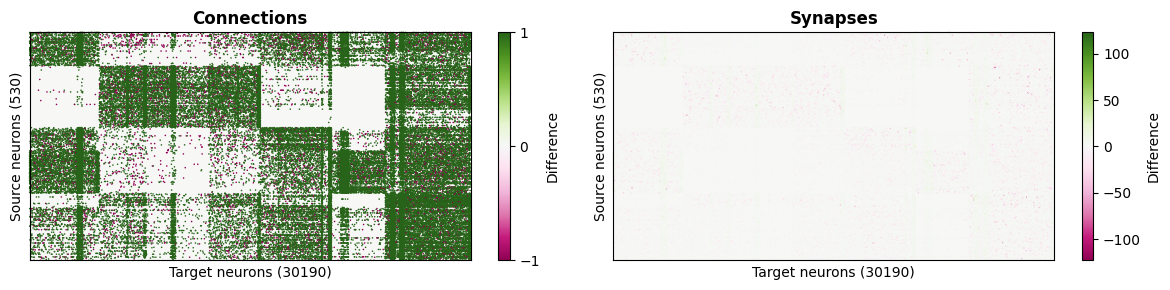

In [50]:
# Plot differences
sub_pct = 10  # Subsampled percentage of connections to display
cmap = 'PiYG'

def get_data(mat):
    mat = mat.tocoo()  # Convert to COO, so that easy access to row/col and corresponding data!!
    return mat.row, mat.col, mat.data

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rows, cols, color_idx = get_data(diff_adj)
vrange = np.abs(color_idx).max()
sub_sel = np.random.choice(len(color_idx), np.round(len(color_idx) * sub_pct / 100).astype(int), replace=False)
plt.scatter(cols[sub_sel], rows[sub_sel], marker='.', s=50.0 / sub_pct, edgecolors='none', alpha=1.0, c=color_idx[sub_sel], cmap=cmap, vmin=-1, vmax=1, clip_on=False)
plt.axis('tight')
plt.xticks([])
plt.yticks([])
plt.xlim(-0.5, diff_adj.shape[1] - 0.5)
plt.ylim(-0.5, diff_adj.shape[0] - 0.5)
plt.gca().invert_yaxis()
plt.gca().set_facecolor(plt.colormaps[cmap](0.5))  # Set background to middle of colormap
plt.xlabel(f'Target neurons ({len(tgt_sel)})')
plt.ylabel(f'Source neurons ({len(src_sel)})')
plt.title('Connections', fontweight='bold')
h_cb = plt.colorbar(label='Difference')
h_cb.set_ticks([-1, 0, 1])

plt.subplot(1, 2, 2)
rows, cols, color_idx = get_data(diff_synaptome)
vrange = np.abs(color_idx).max()
sub_sel = np.random.choice(len(color_idx), np.round(len(color_idx) * sub_pct / 100).astype(int), replace=False)
plt.scatter(cols[sub_sel], rows[sub_sel], marker='.', s=50.0 / sub_pct, edgecolors='none', alpha=1.0, c=color_idx[sub_sel], cmap=cmap, vmin=-vrange, vmax=vrange, clip_on=False)
plt.axis('tight')
plt.xticks([])
plt.yticks([])
plt.xlim(-0.5, diff_synaptome.shape[1] - 0.5)
plt.ylim(-0.5, diff_synaptome.shape[0] - 0.5)
plt.gca().invert_yaxis()
plt.gca().set_facecolor(plt.colormaps[cmap](0.5))  # Set background to middle of colormap
plt.xlabel(f'Target neurons ({len(tgt_sel)})')
plt.ylabel(f'Source neurons ({len(src_sel)})')
plt.title('Synapses', fontweight='bold')
h_cb = plt.colorbar(label='Difference')

plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'conn_diff.png'), dpi=300)
plt.show()

In [51]:
# Check conn. prob. per source m-type
src_mt = nodes.get(src_sel, properties="mtype")
tgt_class = nodes.get(tgt_sel, properties="synapse_class")

p_tab_orig = []
p_tab = []
for st in src_types:
    sel_pre = src_mt == st
    sel_post_e = tgt_class == "EXC"
    sel_post_i = tgt_class == "INH"

    n_e = orig_adj[:, sel_post_e][sel_pre, :].size
    n_i = orig_adj[:, sel_post_i][sel_pre, :].size
    p_e = n_e / (np.sum(sel_pre) * np.sum(sel_post_e))
    p_i = n_i / (np.sum(sel_pre) * np.sum(sel_post_i))
    p_tab_orig.append([p_e, p_i])

    n_e = adj[:, sel_post_e][sel_pre, :].size
    n_i = adj[:, sel_post_i][sel_pre, :].size
    p_e = n_e / (np.sum(sel_pre) * np.sum(sel_post_e))
    p_i = n_i / (np.sum(sel_pre) * np.sum(sel_post_i))
    p_tab.append([p_e, p_i])
p_tab_orig = np.array(p_tab_orig)
p_tab = np.array(p_tab)

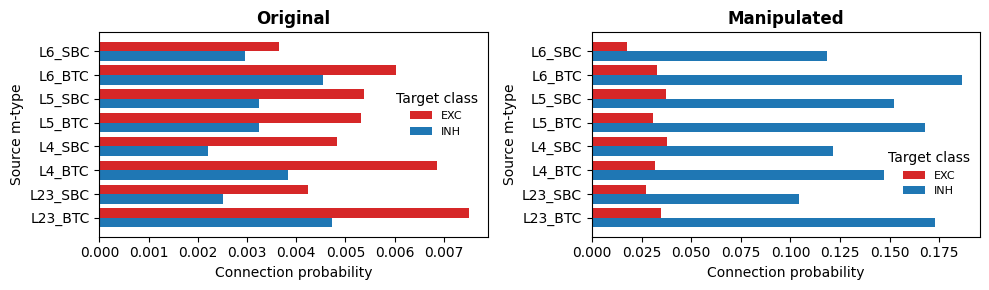

In [53]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(np.arange(len(src_types)) + 0.2, p_tab_orig[:, 0], height=0.4, color="tab:red", label="EXC")
plt.barh(np.arange(len(src_types)) - 0.2, p_tab_orig[:, 1], height=0.4, color="tab:blue", label="INH")
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("Connection probability")
plt.ylabel("Source m-type")
plt.title("Original", fontweight="bold")
plt.legend(title="Target class", frameon=False, fontsize=8, loc="right", bbox_to_anchor=[1.0, 0.6])

plt.subplot(1, 2, 2)
plt.barh(np.arange(len(src_types)) + 0.2, p_tab[:, 0], height=0.4, color="tab:red", label="EXC")
plt.barh(np.arange(len(src_types)) - 0.2, p_tab[:, 1], height=0.4, color="tab:blue", label="INH")
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("Connection probability")
plt.ylabel("Source m-type")
plt.title("Manipulated", fontweight="bold")
plt.legend(title="Target class", frameon=False, fontsize=8, loc="lower right", bbox_to_anchor=[1.0, 0.15])
plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'conn_prob_by_mtype__EXC_vs_INH.png'), dpi=300)
plt.show()

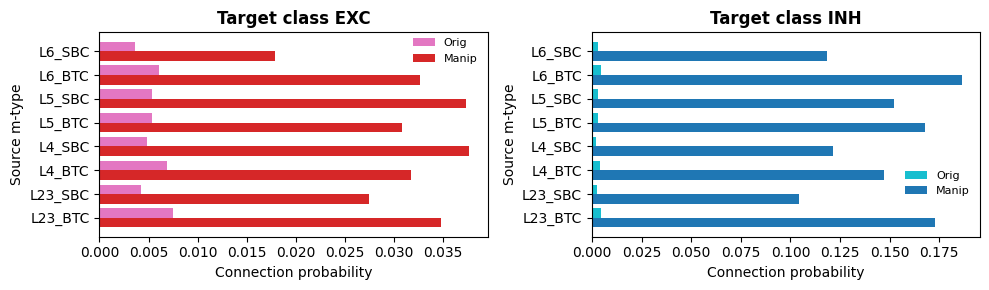

In [54]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(np.arange(len(src_types)) + 0.2, p_tab_orig[:, 0], height=0.4, color="tab:pink", label="Orig")
plt.barh(np.arange(len(src_types)) - 0.2, p_tab[:, 0], height=0.4, color="tab:red", label="Manip")
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("Connection probability")
plt.ylabel("Source m-type")
plt.title("Target class EXC", fontweight="bold")
plt.legend(frameon=False, loc="upper right", fontsize=8, bbox_to_anchor=[1.0, 1.02])

plt.subplot(1, 2, 2)
plt.barh(np.arange(len(src_types)) + 0.2, p_tab_orig[:, 1], height=0.4, color="tab:cyan", label="Orig")
plt.barh(np.arange(len(src_types)) - 0.2, p_tab[:, 1], height=0.4, color="tab:blue", label="Manip")
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("Connection probability")
plt.ylabel("Source m-type")
plt.title("Target class INH", fontweight="bold")
plt.legend(frameon=False, loc="lower right", fontsize=8, bbox_to_anchor=[1.0, 0.15])
plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'conn_prob_by_mtype__orig_vs_manip.png'), dpi=300)
plt.show()

In [55]:
# Check #syn/conn per source m-type
nsynconn_tab_orig = []
nsynconn_tab = []
for st in src_types:
    sel_pre = src_mt == st
    sel_post_e = tgt_class == "EXC"
    sel_post_i = tgt_class == "INH"

    n_e = orig_synaptome[:, sel_post_e][sel_pre, :].size
    n_i = orig_synaptome[:, sel_post_i][sel_pre, :].size
    s_e = orig_synaptome[:, sel_post_e][sel_pre, :].sum()
    s_i = orig_synaptome[:, sel_post_i][sel_pre, :].sum()
    nsc_e = s_e / n_e
    nsc_i = s_i / n_i
    nsynconn_tab_orig.append([nsc_e, nsc_i])

    n_e = synaptome[:, sel_post_e][sel_pre, :].size
    n_i = synaptome[:, sel_post_i][sel_pre, :].size
    s_e = synaptome[:, sel_post_e][sel_pre, :].sum()
    s_i = synaptome[:, sel_post_i][sel_pre, :].sum()
    nsc_e = s_e / n_e
    nsc_i = s_i / n_i
    nsynconn_tab.append([nsc_e, nsc_i])
nsynconn_tab_orig = np.array(nsynconn_tab_orig)
nsynconn_tab = np.array(nsynconn_tab)

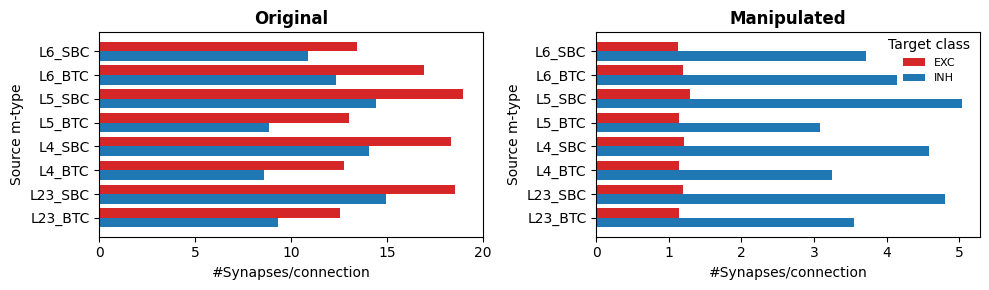

In [56]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(np.arange(len(src_types)) + 0.2, nsynconn_tab_orig[:, 0], height=0.4, color="tab:red", label="EXC")
plt.barh(np.arange(len(src_types)) - 0.2, nsynconn_tab_orig[:, 1], height=0.4, color="tab:blue", label="INH")
plt.xlim([0, 20])
plt.xticks(np.arange(0, 21, 5))
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("#Synapses/connection")
plt.ylabel("Source m-type")
plt.title("Original", fontweight="bold")
# plt.legend(title="Target class", frameon=False, fontsize=8, loc="upper right", bbox_to_anchor=[1.0, 1.0])

plt.subplot(1, 2, 2)
plt.barh(np.arange(len(src_types)) + 0.2, nsynconn_tab[:, 0], height=0.4, color="tab:red", label="EXC")
plt.barh(np.arange(len(src_types)) - 0.2, nsynconn_tab[:, 1], height=0.4, color="tab:blue", label="INH")
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("#Synapses/connection")
plt.ylabel("Source m-type")
plt.title("Manipulated", fontweight="bold")
plt.legend(title="Target class", frameon=False, fontsize=8, loc="upper right", bbox_to_anchor=[1.0, 1.02])
plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'nsynconn_by_mtype__EXC_vs_INH.png'), dpi=300)
plt.show()

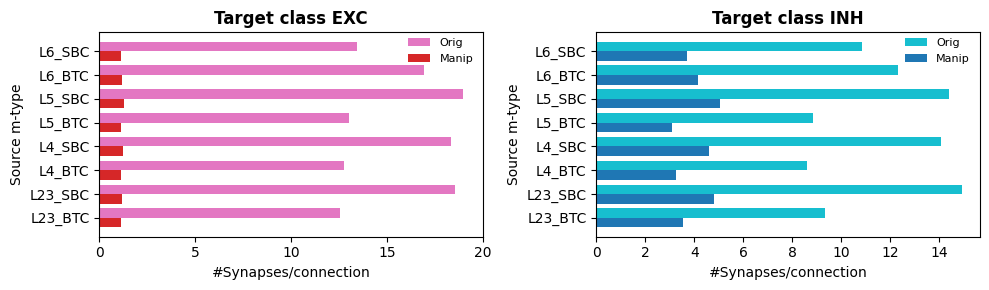

In [57]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(np.arange(len(src_types)) + 0.2, nsynconn_tab_orig[:, 0], height=0.4, color="tab:pink", label="Orig")
plt.barh(np.arange(len(src_types)) - 0.2, nsynconn_tab[:, 0], height=0.4, color="tab:red", label="Manip")
plt.xlim([0, 20])
plt.xticks(np.arange(0, 21, 5))
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("#Synapses/connection")
plt.ylabel("Source m-type")
plt.title("Target class EXC", fontweight="bold")
plt.legend(frameon=False, loc="upper right", fontsize=8, bbox_to_anchor=[1.0, 1.02])

plt.subplot(1, 2, 2)
plt.barh(np.arange(len(src_types)) + 0.2, nsynconn_tab_orig[:, 1], height=0.4, color="tab:cyan", label="Orig")
plt.barh(np.arange(len(src_types)) - 0.2, nsynconn_tab[:, 1], height=0.4, color="tab:blue", label="Manip")
plt.yticks(np.arange(len(src_types)), src_types)
plt.xlabel("#Synapses/connection")
plt.ylabel("Source m-type")
plt.title("Target class INH", fontweight="bold")
plt.legend(frameon=False, loc="upper right", fontsize=8, bbox_to_anchor=[1.0, 1.02])
plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'nsynconn_by_mtype__orig_vs_manip.png'), dpi=300)
plt.show()

In [59]:
# Overall conn. prob. and #syn/conn from all manipulated src types to EXC/INH
sel_post_e = tgt_class == "EXC"
sel_post_i = tgt_class == "INH"

n_e = orig_synaptome[:, sel_post_e].size
n_i = orig_synaptome[:, sel_post_i].size
nconn_all_orig = [n_e, n_i]
p_e = n_e / (orig_adj.shape[0] * np.sum(sel_post_e))
p_i = n_i / (orig_adj.shape[0] * np.sum(sel_post_i))
p_all_orig = np.array([p_e, p_i])

nsc_e = orig_synaptome[:, sel_post_e].data.mean()
nsc_i = orig_synaptome[:, sel_post_i].data.mean()
nsynconn_all_orig = [nsc_e, nsc_i]
s_e = orig_synaptome[:, sel_post_e].sum()
s_i = orig_synaptome[:, sel_post_i].sum()
nsyn_all_orig = [s_e, s_i]

n_e = synaptome[:, sel_post_e].size
n_i = synaptome[:, sel_post_i].size
nconn_all = [n_e, n_i]
p_e = n_e / (adj.shape[0] * np.sum(sel_post_e))
p_i = n_i / (adj.shape[0] * np.sum(sel_post_i))
p_all = np.array([p_e, p_i])

nsc_e = synaptome[:, sel_post_e].data.mean()
nsc_i = synaptome[:, sel_post_i].data.mean()
nsynconn_all = [nsc_e, nsc_i]
s_e = synaptome[:, sel_post_e].sum()
s_i = synaptome[:, sel_post_i].sum()
nsyn_all = [s_e, s_i]

print(f"#conn E/I: {nconn_all_orig} (orig), {nconn_all} (manip)")
print(f"#syn E/I: {nsyn_all_orig} (orig), {nsyn_all} (manip)")
print(f"conn prob E/I: {p_all_orig} (orig), {p_all} (manip)")
print(f"#syn/conn E/I: {nsynconn_all_orig} (orig), {nsynconn_all} (manip)")

#conn E/I: [83369, 6831] (orig), [446368, 287374] (manip)
#syn E/I: [1204043, 72643] (orig), [519620, 1073975] (manip)
conn prob E/I: [0.00587225 0.00378745] (orig), [0.03144077 0.15933444] (manip)
#syn/conn E/I: [14.442334680756636, 10.634314156053286] (orig), [1.1641067460032977, 3.7372030872660713] (manip)


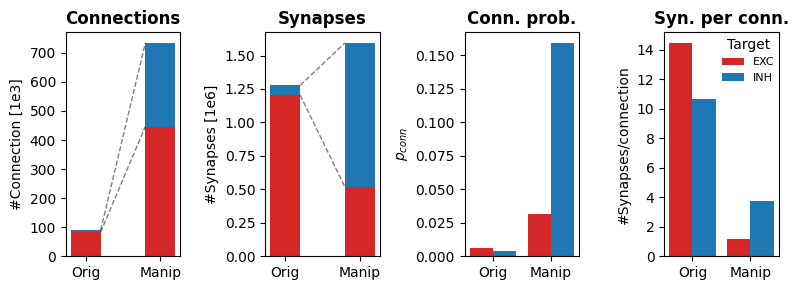

In [60]:
col_e = "tab:red"
col_i = "tab:blue"
x_lbl = ["Orig", "Manip"]

plt.figure(figsize=(8, 3))
plt.subplot(1, 4, 1)
plt.bar(x_lbl, [nconn_all_orig[0] * 1e-3, nconn_all[0] * 1e-3], width=0.4, color=col_e, label="EXC")
plt.bar(x_lbl, [nconn_all_orig[1] * 1e-3, nconn_all[1] * 1e-3], width=0.4, bottom=[nconn_all_orig[0] * 1e-3, nconn_all[0] * 1e-3], color=col_i, label="INH")
plt.plot([0.2, 0.8], [nconn_all_orig[0] * 1e-3, nconn_all[0] * 1e-3], '--k', lw=1, alpha=0.5)
plt.plot([0.2, 0.8], [np.sum(nconn_all_orig) * 1e-3, np.sum(nconn_all) * 1e-3], '--k', lw=1, alpha=0.5)
plt.ylabel("#Connection [1e3]")
plt.title("Connections", fontweight="bold")

plt.subplot(1, 4, 2)
plt.bar(x_lbl, [nsyn_all_orig[0] * 1e-6, nsyn_all[0] * 1e-6], width=0.4, color=col_e, label="EXC")
plt.bar(x_lbl, [nsyn_all_orig[1] * 1e-6, nsyn_all[1] * 1e-6], width=0.4, bottom=[nsyn_all_orig[0] * 1e-6, nsyn_all[0] * 1e-6], color=col_i, label="INH")
plt.plot([0.2, 0.8], [nsyn_all_orig[0] * 1e-6, nsyn_all[0] * 1e-6], '--k', lw=1, alpha=0.5)
plt.plot([0.2, 0.8], [np.sum(nsyn_all_orig) * 1e-6, np.sum(nsyn_all) * 1e-6], '--k', lw=1, alpha=0.5)
plt.ylabel("#Synapses [1e6]")
plt.title("Synapses", fontweight="bold")

plt.subplot(1, 4, 3)
plt.bar(np.arange(len(x_lbl)) - 0.2, [p_all_orig[0], p_all[0]], width=0.4, color=col_e, label="EXC")
plt.bar(np.arange(len(x_lbl)) + 0.2, [p_all_orig[1], p_all[1]], width=0.4, color=col_i, label="INH")
plt.xticks(np.arange(len(x_lbl)), x_lbl)
plt.ylabel("$p_{conn}$")
plt.title("Conn. prob.", fontweight="bold")

plt.subplot(1, 4, 4)
plt.bar(np.arange(len(x_lbl)) - 0.2, [nsynconn_all_orig[0], nsynconn_all[0]], width=0.4, color=col_e, label="EXC")
plt.bar(np.arange(len(x_lbl)) + 0.2, [nsynconn_all_orig[1], nsynconn_all[1]], width=0.4, color=col_i, label="INH")
plt.xticks(np.arange(len(x_lbl)), x_lbl)
plt.ylabel("#Synapses/connection")
plt.title("Syn. per conn.", fontweight="bold")
plt.legend(title="Target", frameon=False, fontsize=8, loc="upper right", bbox_to_anchor=[1.05, 1.02])

plt.tight_layout()
plt.savefig(os.path.join(figs_path, 'overview__EXC_vs_INH.png'), dpi=300)
plt.show()

#### Check synapse positions

ℹ️ The rewired circuit is also contained in the Zenodo dataset. In case that circuit is used, all path references in `circuit_config_tc.json` must be changed according to the original SSCx circuit location!

In [63]:
res_circuit = Circuit(f'{output_circuit_path}/SSCx-HexO1-Release__SSCX_hex0_inh_tc__hex0_rewired/circuit_config_tc.json')
res_edges = res_circuit.edges['S1nonbarrel_neurons__S1nonbarrel_neurons__chemical']
res_nodes = [res_edges.source, res_edges.target]
res_node_ids = [n.ids() for n in res_nodes]
props_sel = ['@source_node', '@target_node', 'afferent_center_x', 'afferent_center_y', 'afferent_center_z', 'afferent_section_id', 'afferent_section_pos', 'afferent_section_type']
res_edges_table = res_edges.pathway_edges(source=src_sel, target=tgt_sel, properties=props_sel)
ref_tab = etab[props_sel]

In [104]:
res_conns = np.unique(res_edges_table[["@source_node", "@target_node"]], axis=0)
N_check = np.round(0.01 * res_conns.shape[0]).astype(int)  # Check 1% of connections
np.random.seed(0)
conns_sel = res_conns[np.random.choice(res_conns.shape[0], size=N_check, replace=False), :]
for s, t in tqdm.tqdm(conns_sel):
    tab1 = res_edges_table.loc[np.logical_and(res_edges_table["@source_node"] == s, res_edges_table["@target_node"] == t)]
    tab2 = ref_tab.loc[np.logical_and(ref_tab["@source_node"] == s, ref_tab["@target_node"] == t)]
    np.testing.assert_array_equal(tab1.to_numpy(), tab2.to_numpy())

100%|██████████| 7337/7337 [01:15<00:00, 96.58it/s]
